# Mod 3 Final Project: Chicago Car Crashes

* Student name: John Cho
* Student pace: full time online
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL: https://medium.com/@johnnyboyee/cars-crashes-and-chicago-e78302c9c861

### The datasets can be found here:
https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if

https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3

https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

As indicated by the links, the data has been subsetted into Crash, Vehicle and People data files. Note that these files are updated quite frequently; this project will use the data downloaded as of **March 12, 2020** totaling 710MB. Number of **rows totaled over 2 million (~400k crashes, 800k vehicles, 850k people) and 151 feature columns (49 crash, 72 vehicle, 30 people).**

>Note: Due to Github being unable to support file sizes larger than 100MB and Git LFS (Large File Storage) not able to push to a public fork, the data import and cleaning was performed locally. Only the pickled files have been saved to the Github notebook and uploaded. The original data files were saved publicly to Google Drive here:
* -[Crashes](https://drive.google.com/file/d/1mNNHH91H8kTLfAcTpWhq1qYs5QMruQlr/view?usp=sharing) --- [Vehicles](https://drive.google.com/file/d/1eYukgCAFZTXnoj1V5ScTC5II7xAAc2Vk/view?usp=sharing) --- [People](https://drive.google.com/file/d/1DBcsZiwyrUgGe1NaKNOOVGxVJDNeWymR/view?usp=sharing)

>In addition, much of the ***initial column selection*** (exploring spread of values, distributions, histograms, linear relationships) was performed outside this notebook by using the City of Chicago's visualization tool (for the sake of time and sanity). They can be found for each dataset at the links below:
* -[Crashes Tool](https://data.cityofchicago.org/d/85ca-t3if/visualization) --- [Vehicles Tool](https://data.cityofchicago.org/d/68nd-jvt3/visualization) --- [People Tool](https://data.cityofchicago.org/d/u6pd-qa9d/visualization)

# What are we trying to predict?
For this project, we will be focusing on ***predicting crashes with at least one (1) severe injury or fatality***. For this dataset, that means a value greater than zero in either the ***Fatal*** or ***Incapacitating*** injury columns. We will be referring to these as ***severe*** crashes vs ***non-severe***.

* *In Python speak, we will be combining both column data into a new feature where 0 (non-severe) will be assigned only if Fatal AND Incapacitating injuries are both equal to zero (sum=0). A 1 (severe) will be assigned if Fatal OR Incapacitating injuries have a value greater than zero (sum>0).*

>***Note: To help manage the size of this dataset we will discard all accidents before Sep 2017.*** Per City of Chicago: "Data from E-Crash are available for some police districts in 2015, but citywide data are not available until September 2017."

As evidenced below, it looks like at least half of citywide crashes are missing from the data until the aforementioned Sep 2017 (assuming vehicular crashes have been fairly constant from 2015 to present; fluctuating around 9-10k/month). So we get to kill 2 birds with one stone - shrinking down our dataset with *pretty decent randomness* AND *increasing prediction accuracy* by ensuring all police destricts are equally represented.

|Crashes|Per|Month|
|:      |: :|:   :|

<img src="Num_crashes_hist.PNG" width="900">

**Image by [Crashes Visualization Tool](https://data.cityofchicago.org/d/85ca-t3if/visualization) via [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)*

# Data Cleaning, Exploring and Transformation
* We will start with the `Crash` dataset and add individual feature columns from `Vehicles`, `People` later.

In [1]:
# Importing libraries, data
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import datetime as dt
import seaborn as sns

# Note that these files won't be found if the files aren't separately downloaded to the local project notebook folder
vehicle_data = pd.read_csv("./Traffic_Crashes_-_Vehicles.csv") 
people_data = pd.read_csv("./Traffic_Crashes_-_People.csv")
crash_data = pd.read_csv("./Traffic_Crashes_-_Crashes.csv")

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,55,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Drop all rows with dates preceding Sep 2017
cutoff = dt.datetime(2017,9,1)  #datetime object for the cutoff (09/01/2017)
# Could not make comparisons or use math operations with default pd.to_datetime converted object, had to use method below
crash_data.CRASH_DATE = crash_data.CRASH_DATE.apply(lambda t: dt.datetime.strptime(t,"%m/%d/%Y %H:%M:%S %p"))

display(crash_data.shape)  #view original size before dropping rows
crash_data = crash_data[crash_data.CRASH_DATE >= cutoff] #retain only crashes with a date on or after cutoff

# Preview dataset info, columns, null values, duplicates
print(crash_data.info(),'\n\n', crash_data.isna().sum(),'\n\n Duplicates: ', crash_data.duplicated().sum(),
      crash_data.CRASH_RECORD_ID.duplicated().sum()) #also verify no duplicate ids

(394103, 49)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294798 entries, 0 to 394102
Data columns (total 49 columns):
CRASH_RECORD_ID                  294798 non-null object
RD_NO                            290377 non-null object
CRASH_DATE_EST_I                 20321 non-null object
CRASH_DATE                       294798 non-null datetime64[ns]
POSTED_SPEED_LIMIT               294798 non-null int64
TRAFFIC_CONTROL_DEVICE           294798 non-null object
DEVICE_CONDITION                 294798 non-null object
WEATHER_CONDITION                294798 non-null object
LIGHTING_CONDITION               294798 non-null object
FIRST_CRASH_TYPE                 294798 non-null object
TRAFFICWAY_TYPE                  294798 non-null object
LANE_CNT                         116285 non-null float64
ALIGNMENT                        294798 non-null object
ROADWAY_SURFACE_COND             294798 non-null object
ROAD_DEFECT                      294798 non-null object
REPORT_TYPE                      286905 no

>#### Note that we dropped almost 100k rows with dates preceding Sep 2017 for a 25% reduction in our dataset.
### Let's eliminate these columns right away:
* `RD_NO` - "Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes" - redundant with CRASH_RECORD_ID for the purposes of this project.
* `CRASH_DATE_EST_I` - "Crash date estimated by desk officer or reporting party (only used in cases where crash is reported at police station days after the crash)" - redundant with CRASH_DATE and too many null values.
* `INTERSECTION_RELATED_I` - "A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection" - despite so many null values, the binary nature of this column (Y/N) makes it easy to deal with them. We'll keep this for now in case it is a good candidate for our predictor.
* `NOT_RIGHT_OF_WAY_I, PHOTOS_TAKEN_I, STATEMENTS_TAKEN_I, DOORING_I, WORK_ZONE_I, WORK_ZONE_TYPE, WORKERS_PRESENT_I` - too many null values and/or not relevant to our target prediction.
* `LOCATION` - redundant information (longitude + latitude values)

In [3]:
crash_data.drop(labels=['RD_NO','CRASH_DATE_EST_I','INTERSECTION_RELATED_I','NOT_RIGHT_OF_WAY_I','PHOTOS_TAKEN_I',
                        'STATEMENTS_TAKEN_I','DOORING_I','WORK_ZONE_I','WORK_ZONE_TYPE','WORKERS_PRESENT_I','LOCATION'],
                axis=1,inplace=True)

# Examining lane count values
crash_data.LANE_CNT.value_counts(dropna=False)

NaN         178513
2.0          53727
4.0          29604
1.0          18834
3.0           5073
0.0           3959
6.0           2488
5.0           1192
8.0           1046
7.0            127
10.0            88
9.0             42
11.0            24
12.0            20
99.0            19
22.0             7
15.0             5
20.0             5
16.0             4
60.0             3
30.0             3
14.0             2
25.0             2
28.0             1
19.0             1
17.0             1
40.0             1
41.0             1
21.0             1
100.0            1
400.0            1
13.0             1
433634.0         1
45.0             1
Name: LANE_CNT, dtype: int64

> Note that the plots created using Chicago's visualization tool are off of the entire dataset while we are working with the earlier (before 9/1/17) data dropped.

<img src="LANE_CNT.PNG" width=950>

#### The LANE_CNT column is described as: "Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection)."
* Seeing how many high lane values there are, one questions if these are data entry mistakes. Maybe some of these values are coded for something else.. for instance '99' appears over 100 times (in original dataset). It is hard to believe that over 12 lane roads (6 lane highways) exist in Chicago.

**Let's examine the spread of values in regards to number of lanes and increased risk of severe accidents. Initially it appears that this column represents a discrete variable (where linear regression could apply) but in regards to predicting our target, it is more categorical.**
* `0` (intersections), `1` (single lane 1way), `2` (single lane 2way, rarely double lane 1way) - each represent distinctly different situations all at lower city speeds, often requiring a pedestrian/bicyclist to be involved for a *severe* accident. If only vehicles are involved, fatalities and incapacitating injuries are rare due to the low speeds, coupled with the advent of modern safety technologies (anti-lock brakes, seatbelts, airbags, stability control, automatic emergency braking). This group 'shares the road' the most by far with pedestrians (not protected by a 'cage' - as motorcyclists would call it) vs the other 2 groups below.
* `3-5` - three, four and five lane roads usually have more in common: higher (medium) speed limits but stricter safety measures in place: traffic lights, crosswalks, bike lanes, barriers, etc. Proximity and frequency of interactions with pedestrians is definitely less than the group above but more than the group below.
* `6+` - any roads with 6 lanes or more should almost always be freeways with the highest speed limits and near zero interaction with pedestrians and bicyclists. The caveat is that higher speeds increase the severity of crashes.
* `NaN` - considering the high amount of null values (almost half of the dataset) and the categorical nature of this feature we will treat this as its own bin. We can call it 'unknown' for now but common methods of replacing them with average values would likely serve to only dilute predictions, reduce accuracy and possibly introduce bias. In fact, only after Googling it did we discover that this is an acceptable method!

<img src="Missing_data.PNG" width="550">

#### Let's 'bin' these LANE_CNT values accordingly:
`0,1,2,3,4,5`: leave these untouched.
`6+`: convert to value of 6.
`NaN`: null values will be converted to -1.

In [4]:
crash_data.LANE_CNT.fillna(value=-1,inplace=True)
crash_data.LANE_CNT = crash_data.LANE_CNT.apply(lambda x: x if x<6 else 6)
crash_data.LANE_CNT = crash_data.LANE_CNT.astype('int64')
display(crash_data.LANE_CNT.value_counts(dropna=False))

# Examining report type, hit and run values
print(crash_data.REPORT_TYPE.value_counts(dropna=False),'\n\n',crash_data.HIT_AND_RUN_I.value_counts(dropna=False))

-1    178513
 2     53727
 4     29604
 1     18834
 3      5073
 0      3959
 6      3896
 5      1192
Name: LANE_CNT, dtype: int64

NOT ON SCENE (DESK REPORT)    154279
ON SCENE                      132626
NaN                             7893
Name: REPORT_TYPE, dtype: int64 

 NaN    212496
Y       78702
N        3600
Name: HIT_AND_RUN_I, dtype: int64


<img src="REPORT_TYPE.PNG" width=750>

#### Filling in these null values should be fairly straightforward: 
- `REPORT_TYPE` - can safely assume NOT ON SCENE because officers being dispatched requires additional resources / coordination / paperwork, making it very unlikely that these would be missing data entries. As we can see below, it appears that ON SCENE reports is well correlated with severe injuries.
- `HIT_AND_RUN_I` - despite so many null values, an 'unknown' or 'n/a' value should imply that there was no hit and run. This is often a crucial detail in police reports used for insurance claims.
- **While we're at it, let's convert ON SCENE / Y to 1 and DESK / N to 0.**

In [5]:
crash_data.REPORT_TYPE.fillna(value='NOT ON SCENE (DESK REPORT)',inplace=True)
crash_data.HIT_AND_RUN_I.fillna(value='N',inplace=True)

# Replacing with binary values 1 (ON SCENE / Y) and 0 (DESK REPORT / N)
crash_data.REPORT_TYPE = crash_data.REPORT_TYPE.apply(lambda x: 1 if x=='ON SCENE' else 0)
crash_data.HIT_AND_RUN_I = crash_data.HIT_AND_RUN_I.apply(lambda x: 1 if x=='Y' else 0)
print(crash_data.REPORT_TYPE.value_counts(dropna=False),'\n\n',crash_data.HIT_AND_RUN_I.value_counts(dropna=False))

0    162172
1    132626
Name: REPORT_TYPE, dtype: int64 

 0    216096
1     78702
Name: HIT_AND_RUN_I, dtype: int64


In [6]:
# Taking a closer look at CRASH_DATE vs DATE_POLICE_NOTIFIED
crash_data.loc[:, ['CRASH_DATE','DATE_POLICE_NOTIFIED']].head(3)

,CRASH_DATE,DATE_POLICE_NOTIFIED
0,2019-03-27 04:20:00,03/27/2019 04:27:00 PM
1,2018-03-06 03:00:00,03/06/2018 04:10:00 PM
3,2020-01-21 04:16:00,01/21/2020 04:18:00 PM


#### Police notified date/time should always be later or equal (>=) to crash date/time and as we are only focusing on actual crash relevant data, we will drop this column.
>However, there could be significance in the ***time difference*** between the two - severe crashes will often be followed up by an immediate call to 911. A long lag time between the two would more often be associated with non-severe crashes. Let's convert `DATE_POLICE_NOTIFIED` to `POL_NOTIFY_TIME` (in hours).

In [7]:
# Convert DATE_POLICE_NOTIFIED to same datetime object as CRASH_DATE
crash_data.DATE_POLICE_NOTIFIED=crash_data.DATE_POLICE_NOTIFIED.apply(lambda t: dt.datetime.strptime(t,"%m/%d/%Y %H:%M:%S %p"))
crash_data['POL_NOTIFY_TIME'] = crash_data.DATE_POLICE_NOTIFIED - crash_data.CRASH_DATE  #create new column for time difference
crash_data.POL_NOTIFY_TIME = crash_data.POL_NOTIFY_TIME.dt.seconds.astype('int64') / 60  #convert to total number of minutes
crash_data.POL_NOTIFY_TIME = crash_data.POL_NOTIFY_TIME.astype('int64')

print(crash_data.POL_NOTIFY_TIME.head(3), '\n\n', crash_data.POL_NOTIFY_TIME.describe())

0     7
1    70
3     2
Name: POL_NOTIFY_TIME, dtype: int64 

 count    294798.000000
mean        189.887564
std         371.849093
min           0.000000
25%           5.000000
50%          27.000000
75%         105.000000
max        1439.000000
Name: POL_NOTIFY_TIME, dtype: float64


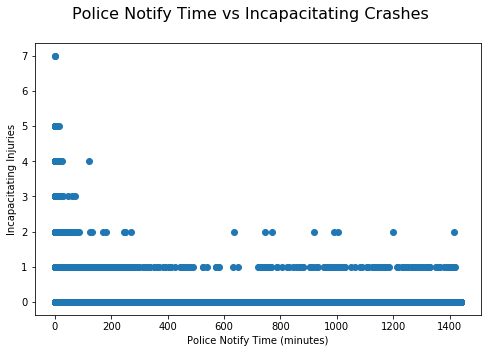

In [8]:
# View scatter plot of police notify time vs incapacitating injuries
fig = plt.figure(figsize=(8, 5))
fig.suptitle('Police Notify Time vs Incapacitating Crashes', fontsize=16)
plt.scatter(crash_data.POL_NOTIFY_TIME, crash_data.INJURIES_INCAPACITATING)
plt.xlabel('Police Notify Time (minutes)')
plt.ylabel('Incapacitating Injuries')
plt.show()

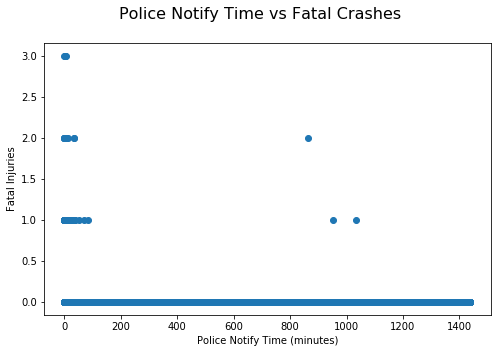

In [9]:
# View scatter plot of police notify time vs fatal injuries
fig = plt.figure(figsize=(8, 5))
fig.suptitle('Police Notify Time vs Fatal Crashes', fontsize=16)
plt.scatter(crash_data.POL_NOTIFY_TIME, crash_data.INJURIES_FATAL)
plt.xlabel('Police Notify Time (minutes)')
plt.ylabel('Fatal Injuries')
plt.show()

#### There appears to be some negative correlation (albeit weak) between a quicker call to 911 and severe crashes.

Note that the useful information from `CRASH_DATE` has already been parsed into `CRASH_HOUR/DAY_OF_WEEK/MONTH` so we can go ahead and drop both columns.

In [10]:
crash_data.drop('DATE_POLICE_NOTIFIED',axis=1,inplace=True)
crash_data.drop('CRASH_DATE',axis=1,inplace=True)

# Moving onto STREET_DIRECTION, STREET_NAME, BEAT_OF_OCCURRENCE
print(crash_data.STREET_DIRECTION.value_counts(dropna=False),'\n\n',crash_data.STREET_NAME.value_counts(dropna=False),
     '\n\n',crash_data.BEAT_OF_OCCURRENCE.value_counts(dropna=False))

W    107300
S     93537
N     74542
E     19419
Name: STREET_DIRECTION, dtype: int64 

 WESTERN AVE       8192
PULASKI RD        7018
ASHLAND AVE       6430
CICERO AVE        6296
HALSTED ST        5634
                  ... 
MEMORY LN            1
FOREMAN DR           1
ISHAM AVE            1
GOVERNORS PKWY       1
20TH PL              1
Name: STREET_NAME, Length: 1468, dtype: int64 

 1834.0    4060
1831.0    3303
114.0     3286
122.0     3186
813.0     2859
          ... 
422.0      250
1653.0     152
1652.0      67
1655.0      64
6100.0       1
Name: BEAT_OF_OCCURRENCE, Length: 275, dtype: int64


#### As there is no good way to replace these null values and with so few (7 total) we will go ahead and drop the rows with null values.

In [11]:
crash_data.STREET_DIRECTION.dropna(axis=0,inplace=True)
crash_data.STREET_NAME.dropna(axis=0,inplace=True)
crash_data.BEAT_OF_OCCURRENCE.dropna(axis=0,inplace=True)

#Checking out NUM_UNITS
crash_data.NUM_UNITS.value_counts(dropna=False)

2.0     255882
1.0      17831
3.0      15691
4.0       2851
NaN       1578
5.0        665
6.0        181
7.0         71
8.0         23
9.0         11
10.0         7
12.0         2
11.0         2
15.0         1
18.0         1
16.0         1
Name: NUM_UNITS, dtype: int64

#### This column is described as: 'Number of units involved in the crash. A unit can be a motor vehicle, a pedestrian, a bicyclist, or another non-passenger roadway user. Each unit represents a mode of traffic with an independent trajectory.'
It looks like 2 is pretty popular. Certainly the mode and median, probably close to the mean as well.

In [12]:
print(f'median: {crash_data.NUM_UNITS.median()}', f'mean: {crash_data.NUM_UNITS.mean()}')

median: 2.0 mean: 2.0238319350658207


#### That makes it pretty easy! These null values can be replaced by not just one average, but essentially all 3!

In [13]:
crash_data.NUM_UNITS.fillna(value=2, inplace=True)

# Loop thru the next 8 injury related columns for unique values and print averages
for col in crash_data.columns:
    if 'INJUR' in col:
        print(col,'\n',crash_data[col].value_counts(dropna=False))
        try:  #for MOST_SEVERE_INJURY string values throwing error
            print(f'Median: {crash_data[col].median()}',f'Mean: {crash_data[col].mean()}','\n')
        except: print('\n')

MOST_SEVERE_INJURY 
 NO INDICATION OF INJURY     252083
NONINCAPACITATING INJURY     22551
REPORTED, NOT EVIDENT        12494
INCAPACITATING INJURY         5150
NaN                           2258
FATAL                          262
Name: MOST_SEVERE_INJURY, dtype: int64


INJURIES_TOTAL 
 0.0     252086
1.0      31128
2.0       6371
NaN       2255
3.0       1879
4.0        655
5.0        246
6.0         98
7.0         39
9.0         15
8.0          8
10.0         6
11.0         4
15.0         3
21.0         2
13.0         1
16.0         1
19.0         1
Name: INJURIES_TOTAL, dtype: int64
Median: 0.0 Mean: 0.18683065395514506 

INJURIES_FATAL 
 0.0    292281
NaN      2255
1.0       246
2.0        12
3.0         4
Name: INJURIES_FATAL, dtype: int64
Median: 0.0 Mean: 0.0009639608536181006 

INJURIES_INCAPACITATING 
 0.0    287358
1.0      4587
NaN      2255
2.0       445
3.0       101
4.0        42
5.0         8
7.0         2
Name: INJURIES_INCAPACITATING, dtype: int64
Median: 0.0 Mean: 0.

* `MOST_SEVERE_INJURY` - we can drop this column as the information is redundant; we'll just note that for consistency we should have a total of **5412** crashes with 'severe' injuries (5150+262).
* `INJURIES_TOTAL` - replace all NaN values with 0.
* `INJURIES_FATAL,INCAPACITATING` - replace null values with 0 and combine to create a new column `SEVERE` for our target prediction. The sum of both column values will determine severity (sum>0 = 1 else 0).
* `INJURIES_NON_INCAPACITATING,REPORTED_NOT_EVIDENT,NO_INDICATION,UNKNOWN` - drop these columns as they are not useful.

In [14]:
crash_data.drop(labels=['INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION',
                        'INJURIES_UNKNOWN','MOST_SEVERE_INJURY'],axis=1,inplace=True)

crash_data.INJURIES_TOTAL.fillna(value=0.0,inplace=True)
crash_data.INJURIES_FATAL.fillna(value=0.0,inplace=True)
crash_data.INJURIES_INCAPACITATING.fillna(value=0.0,inplace=True)

# Create new target column 'SEVERE'
crash_data['SEVERE'] = crash_data.INJURIES_FATAL + crash_data.INJURIES_INCAPACITATING
crash_data.SEVERE = crash_data.SEVERE.map(lambda s: 1 if s>0 else s)  #convert all nonzero values to 1
crash_data.SEVERE = crash_data.SEVERE.astype('int64')
crash_data.drop(labels=['INJURIES_FATAL','INJURIES_INCAPACITATING'],axis=1,inplace=True)
crash_data.SEVERE.value_counts()

0    289386
1      5412
Name: SEVERE, dtype: int64

In [15]:
# Good - the total 5412 matches the sum from MOST_SEVERE_INJURY.. now viewing final 2 columns
print(crash_data.LATITUDE.value_counts(dropna=False),f'Mean: {crash_data.LATITUDE.mean()}',
      f'Median: {crash_data.LATITUDE.median()}','\n\n',crash_data.LONGITUDE.value_counts(dropna=False),
      f'Mean: {crash_data.LONGITUDE.mean()}',f'Median: {crash_data.LONGITUDE.median()}')

NaN          1728
41.976201     459
41.751461     174
41.791420     170
41.722257     154
             ... 
41.876616       1
41.774120       1
41.855599       1
41.801141       1
41.663379       1
Name: LATITUDE, Length: 148919, dtype: int64 Mean: 41.8598323518765 Median: 41.879487548 

  NaN          1728
-87.905309     459
-87.585972     174
-87.580148     170
-87.585276     154
              ... 
-87.751774       1
-87.665544       1
-87.624284       1
-87.699540       1
-87.628000       1
Name: LONGITUDE, Length: 148917, dtype: int64 Mean: -87.67434946796534 Median: -87.674586492


#### We'll replace null values with the median.

In [16]:
crash_data.LATITUDE.fillna(value=crash_data.LATITUDE.median(),inplace=True)
crash_data.LONGITUDE.fillna(value=crash_data.LONGITUDE.median(),inplace=True)

### For the sake of project time and model complexity, we will be dropping the majority of columns that have a large (or difficult to interpret) spread of values and/or less relevance in predicting our target variable.
A full list of these features and descriptions can be found [here](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if).

In [17]:
# Making CRASH_RECORD_ID the index
crash_data.set_index('CRASH_RECORD_ID',inplace=True)

# Show list of values for every column
for col in crash_data.columns:
    print(crash_data[col].value_counts(),'\n',crash_data[col].describe(),'\n')

30    217700
35     20531
25     17949
20     11668
15     10091
10      5835
0       3720
40      2744
5       2298
45      1719
55       264
3         81
50        53
39        29
9         26
60        16
2         14
1         13
32         9
24         6
11         5
6          5
33         4
65         3
70         3
14         2
36         2
22         1
23         1
12         1
26         1
7          1
31         1
4          1
34         1
Name: POSTED_SPEED_LIMIT, dtype: int64 
 count    294798.000000
mean         28.362072
std           6.299569
min           0.000000
25%          30.000000
50%          30.000000
75%          30.000000
max          70.000000
Name: POSTED_SPEED_LIMIT, dtype: float64 

NO CONTROLS                 168463
TRAFFIC SIGNAL               82493
STOP SIGN/FLASHER            29933
UNKNOWN                       9245
OTHER                         1824
LANE USE MARKING               956
YIELD                          425
OTHER REG. SIGN                3

NOT APPLICABLE                                                                      121372
UNABLE TO DETERMINE                                                                 101689
FAILING TO REDUCE SPEED TO AVOID CRASH                                               12688
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                   9445
FAILING TO YIELD RIGHT-OF-WAY                                                         9020
FOLLOWING TOO CLOSELY                                                                 7912
IMPROPER OVERTAKING/PASSING                                                           4298
IMPROPER LANE USAGE                                                                   4274
WEATHER                                                                               4122
IMPROPER TURNING/NO SIGNAL                                                            3085
IMPROPER BACKING                                                                      2393

In [18]:
# Drop unneeded columns
crash_data.drop(labels=['CRASH_TYPE','TRAFFICWAY_TYPE','PRIM_CONTRIBUTORY_CAUSE','SEC_CONTRIBUTORY_CAUSE','STREET_NO',
                        'STREET_NAME'],axis=1,inplace=True)
# Save lat/long for visual map
latlong = pd.DataFrame()
latlong['LATITUDE'] = crash_data.LATITUDE
latlong['LONGITUDE'] = crash_data.LONGITUDE
crash_data.drop(labels=['LATITUDE','LONGITUDE'],axis=1,inplace=True)

## Transformation - Binning 
### As we can see, many of these feature columns have a large spread of unique values that will need to be 'binned'. The main reason for this is that every unique value for each feature will be treated as an individual feature (dimension) when creating models. This is to increase performance and interpretability as well as keep its computation time manageable.
* `POSTED_SPEED_LIMIT` - 3 bins representing low/medium/high (one also has to wonder about the 3700 crashes with a speed limit of 0). Low = 0-15mph, Mid = 16-45, High = 46+
* `TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION` - These can be simplified and combined into a new category `NO_TCD` (Traffic Control Device) indicating either a missing or malfunctioning TCD. We will code a 1 for NO CONTROLS, FUNCTIONING IMPROPERLY, NOT FUNCTIONING, MISSING. This can be useful to the city if certain high risk areas can be mitigated by installing a TCD.
* `WEATHER_CONDITION` - We can combine UNKNOWN and OTHER into a single bin; CLOUDY/OVERCAST can be lumped with RAIN as they are similar; SNOW, SLEET/HAIL, FREEZING RAIN/DRIZZLE, BLOWING SNOW can be combined into SNOW/ICY; the last 2 can be combined into HEAVY WINDS.
* `LIGHTING_CONDITION` - All are significant except we seem to have another null value (UNKNOWN) - we will use the CRASH_HOUR data to fill in values of DUSK/DAWN/DAYLIGHT/DARKNESS.
* `FIRST_CRASH_TYPE` - We will combine the SIDESWIPEs, TURNING / ANGLE, PARKED VEHICLE / FIXED OBJECT, PEDESTRIAN / PEDALCYCLIST / OTHER OBJECT / ANIMAL, HEAD ON / OVERTURNED / TRAIN (most severe types), and the remaining into a 'non-specific' bin.
* `ALIGNMENT` - We will create 3 bins: STRAIGHT, CURVE and HILLCREST.
* `ROADWAY_SURFACE_COND` - Combine UNKNOWN / OTHER and SNOW / ICE / SAND.
* `ROAD_DEFECT` - Combine WORN / SHOULDER / RUT (preventable via road maintenance) and UNKNOWN / OTHER / DEBRIS (not preventable).
* `DAMAGE` - For predicting severe crashes we can safely combine the lesser 2 categories into $1500 OR LESS
* `STREET_DIRECTION` - Combine S,W (sunset) and N,E (sunrise).
* `BEAT_OF_OCCURRENCE` - Listed as: 'Chicago Police Department Beat ID. Boundaries available at https://data.cityofchicago.org/d/aerh-rz74.'
* `NUM_UNITS, INJURIES_TOTAL` - Group everything 3+. Vast majority of collisions involve 1 or 2 units but beyond that the chance of a severe accident should increase substantially (and nominally once above 2). Same goes for total injuries.
* `CRASH_HOUR` - Group into 5a-7a (dawn), 10a-4p (day), 5p-7p (dusk), 8p-4a (night)
* `CRASH_DAY_OF_WEEK` - We'll create a binary category: leisure (Fri/Sat/Sun) vs work (Mon-Thu)
* `CRASH_MONTH` - Group into cold/holiday (Nov-Feb), mild/cool (Mar/Apr/May/Oct), hot/vacation (Jun-Sep)
* `POL_NOTIFY_TIME` - 0-10 (quick), 11-30 (low), 31-120 (mid), 120+ minutes (high)

#### Below are some examples of plots created using Chicago's Visualization tool which helped drive the decision making of feature selection and binning / combining values.

<img src="FIRST_CRASH_TYPE.PNG" width="950">

<img src="NUM_UNITS.PNG" width="950">

<img src="TCD.PNG" width="950">

In [19]:
# Perform binning and transformations
# POSTED_SPEED_LIMIT - create 3 bins
crash_data.POSTED_SPEED_LIMIT = crash_data.POSTED_SPEED_LIMIT.apply(lambda s: 'high' if s>=46 else ('med' if s>=16 else 'low'))

# Creating NO_TCD from TRAFFIC_CONTROL_DEVICE and DEVICE_CONDITION
temp = ['NO CONTROLS','FUNCTIONING IMPROPERLY','NOT FUNCTIONING','MISSING']  #array of NO_TCD values to be assigned 1
crash_data['NO_TCD'] = crash_data.TRAFFIC_CONTROL_DEVICE.apply(lambda s: 1 if s in temp else 0)
crash_data['NO_TCD2'] = crash_data.DEVICE_CONDITION.apply(lambda s: 1 if s in temp else 0)
crash_data.NO_TCD = crash_data.NO_TCD + crash_data.NO_TCD2  #adding results of both columns to capture overlap
crash_data['NO_TCD'] = crash_data.NO_TCD.apply(lambda s: 1 if s==2 else s)  #making all the 2s into 1s
crash_data.drop(['NO_TCD2','TRAFFIC_CONTROL_DEVICE','DEVICE_CONDITION'],axis=1,inplace=True)

# WEATHER_CONDITION - combining similar events
crash_data.WEATHER_CONDITION = crash_data.WEATHER_CONDITION.apply(lambda s: 'UNKNOWN/OTHER' if s in ['UNKNOWN','OTHER'] else s)
crash_data.WEATHER_CONDITION = crash_data.WEATHER_CONDITION.apply(lambda s: 'CLOUDY/RAIN' if s in ['CLOUDY/OVERCAST','RAIN']
                                                                  else s)
crash_data.WEATHER_CONDITION = crash_data.WEATHER_CONDITION.apply(lambda s: 'SNOW/ICY' if s in
                                                                  ['SNOW','SLEET/HAIL','FREEZING RAIN/DRIZZLE','BLOWING SNOW']
                                                                  else s)
crash_data.WEATHER_CONDITION = crash_data.WEATHER_CONDITION.apply(lambda s: 'SEVERE_WINDS' if s in
                                                                  ['SEVERE CROSS WIND GATE','BLOWING SAND, SOIL, DIRT'] else s)

# LIGHTING_CONDITION - use for loops to update unknown values for each range of daily hours
for i in crash_data[crash_data.LIGHTING_CONDITION=='UNKNOWN'][crash_data.CRASH_HOUR>=5][crash_data.CRASH_HOUR<=7].index:
    crash_data.LIGHTING_CONDITION.loc[i] = 'DAWN'
for i in crash_data[crash_data.LIGHTING_CONDITION=='UNKNOWN'][crash_data.CRASH_HOUR>=8][crash_data.CRASH_HOUR<=16].index:
    crash_data.LIGHTING_CONDITION.loc[i] = 'DAYLIGHT'
for i in crash_data[crash_data.LIGHTING_CONDITION=='UNKNOWN'][crash_data.CRASH_HOUR>=17][crash_data.CRASH_HOUR<=19].index:
    crash_data.LIGHTING_CONDITION.loc[i] = 'DUSK'
for i in crash_data[crash_data.LIGHTING_CONDITION=='UNKNOWN'].index:  #remainder will be >=20 and <=4
    crash_data.LIGHTING_CONDITION.loc[i] = 'DARKNESS'

# FIRST_CRASH_TYPE - combining similar events
crash_data.FIRST_CRASH_TYPE = crash_data.FIRST_CRASH_TYPE.apply(lambda s: 'SIDESWIPE' if 'SIDESWIPE' in s else s)
crash_data.FIRST_CRASH_TYPE = crash_data.FIRST_CRASH_TYPE.apply(lambda s: 'TURN/ANGLE' if s in ['TURNING','ANGLE'] else s)
crash_data.FIRST_CRASH_TYPE = crash_data.FIRST_CRASH_TYPE.apply(lambda s: 'PARKED/FIXED' if s in 
                                                                ['PARKED MOTOR VEHICLE','FIXED OBJECT'] else s)
crash_data.FIRST_CRASH_TYPE = crash_data.FIRST_CRASH_TYPE.apply(lambda s: 'PED/CYCLE/OTHER' if s in 
                                                                ['PEDESTRIAN','PEDALCYCLIST','OTHER OBJECT','ANIMAL'] else s)
crash_data.FIRST_CRASH_TYPE = crash_data.FIRST_CRASH_TYPE.apply(lambda s: 'HEAD/OVER/TRAIN' if s in 
                                                                ['HEAD ON','OVERTURNED','TRAIN'] else s)
crash_data.FIRST_CRASH_TYPE = crash_data.FIRST_CRASH_TYPE.apply(lambda s: 'REAR/NONCOL' if s in
                                                                ['REAR END','REAR TO FRONT','OTHER NONCOLLISION','REAR TO SIDE',
                                                                 'REAR TO REAR'] else s)

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [20]:
# ALIGNMENT
crash_data.ALIGNMENT = crash_data.ALIGNMENT.apply(lambda s: 'HILLCREST' if 'HILLCREST' in s else s)
crash_data.ALIGNMENT = crash_data.ALIGNMENT.apply(lambda s: 'CURVE' if 'CURVE' in s else s)
crash_data.ALIGNMENT = crash_data.ALIGNMENT.apply(lambda s: 'STRAIGHT' if 'STRAIGHT' in s else s)

# ROADWAY_SURFACE_COND
crash_data.ROADWAY_SURFACE_COND = crash_data.ROADWAY_SURFACE_COND.apply(lambda s: 'UNKNOWN/OTHER' if s in ['UNKNOWN','OTHER'] 
                                                                        else s)
crash_data.ROADWAY_SURFACE_COND = crash_data.ROADWAY_SURFACE_COND.apply(lambda s: 'SNOW/ICE/SAND' if s in
                                                                        ['SNOW OR SLUSH','ICE','SAND, MUD, DIRT'] else s)
# ROAD_DEFECT
crash_data.ROAD_DEFECT = crash_data.ROAD_DEFECT.apply(lambda s: 'UNKNOWN/OTHER/DEBRIS' if s in
                                                      ['UNKNOWN','OTHER','DEBRIS ON ROADWAY'] else s)
crash_data.ROAD_DEFECT = crash_data.ROAD_DEFECT.apply(lambda s: 'WORN/SHOULDER/RUT' if s in
                                                      ['RUT, HOLES','WORN SURFACE','SHOULDER DEFECT'] else s)
# DAMAGE, STREET_DIRECTION
crash_data.DAMAGE = crash_data.DAMAGE.apply(lambda s: s if s=='OVER $1,500' else '$1500 OR LESS')
crash_data.STREET_DIRECTION = crash_data.STREET_DIRECTION.apply(lambda s: 'S/W' if s in ['S','W'] else 'N/E')

# NUM_UNITS, INJURIES_TOTAL
crash_data.NUM_UNITS = crash_data.NUM_UNITS.apply(lambda s: 3 if s>=3 else s)
crash_data.INJURIES_TOTAL = crash_data.INJURIES_TOTAL.apply(lambda s: 3 if s>=3 else s)
crash_data.NUM_UNITS = crash_data.NUM_UNITS.astype('int64')
crash_data.INJURIES_TOTAL = crash_data.INJURIES_TOTAL.astype('int64')

# CRASH_HOUR - first convert to numbers to prevent for loop errors then convert to strings
crash_data.CRASH_HOUR = crash_data.CRASH_HOUR.apply(lambda s: 'DAWN' if s in [5,6,7] else s)
crash_data.CRASH_HOUR = crash_data.CRASH_HOUR.apply(lambda s: 'DAY' if s in [8,9,10,11,12,13,14,15,16] else s)
crash_data.CRASH_HOUR = crash_data.CRASH_HOUR.apply(lambda s: 'DUSK' if s in [17,18,19] else s)
crash_data.CRASH_HOUR = crash_data.CRASH_HOUR.apply(lambda s: 'NIGHT' if type(s) is int else s)

# CRASH_DAY_OF_WEEK, CRASH_MONTH
crash_data.CRASH_DAY_OF_WEEK = crash_data.CRASH_DAY_OF_WEEK.apply(lambda s: 'LEISURE' if s in [1,6,7] else 'WORK')
crash_data.CRASH_MONTH = crash_data.CRASH_MONTH.apply(lambda s: 'COLD' if s in [11,12,1,2] else s)
crash_data.CRASH_MONTH = crash_data.CRASH_MONTH.apply(lambda s: 'MILD' if s in [3,4,5,10] else s)
crash_data.CRASH_MONTH = crash_data.CRASH_MONTH.apply(lambda s: 'HOT' if s in [6,7,8,9] else s)

# POL_NOTIFY_TIME
crash_data.POL_NOTIFY_TIME = crash_data.POL_NOTIFY_TIME.apply(lambda s: -3 if s>120 else s)
crash_data.POL_NOTIFY_TIME = crash_data.POL_NOTIFY_TIME.apply(lambda s: -2 if s>=31 else s)
crash_data.POL_NOTIFY_TIME = crash_data.POL_NOTIFY_TIME.apply(lambda s: -1 if s>=11 else s)
crash_data.POL_NOTIFY_TIME = crash_data.POL_NOTIFY_TIME.apply(lambda s: 'QUICK' if s>=0 else s)
crash_data.POL_NOTIFY_TIME = crash_data.POL_NOTIFY_TIME.apply(lambda s: 'LOW' if s==-1 else s)
crash_data.POL_NOTIFY_TIME = crash_data.POL_NOTIFY_TIME.apply(lambda s: 'MID' if s==-2 else s)
crash_data.POL_NOTIFY_TIME = crash_data.POL_NOTIFY_TIME.apply(lambda s: 'HIGH' if s==-3 else s)

# Review newly created bins
for col in crash_data.columns:
    print(crash_data[col].value_counts(),'\n')

med     272366
low      22093
high       339
Name: POSTED_SPEED_LIMIT, dtype: int64 

CLEAR             229824
CLOUDY/RAIN        37124
SNOW/ICY           14307
UNKNOWN/OTHER      12863
FOG/SMOKE/HAZE       619
SEVERE_WINDS          61
Name: WEATHER_CONDITION, dtype: int64 

DAYLIGHT                  194094
DARKNESS, LIGHTED ROAD     65262
DARKNESS                   17825
DUSK                       10963
DAWN                        6654
Name: LIGHTING_CONDITION, dtype: int64 

PARKED/FIXED       79083
TURN/ANGLE         73828
REAR/NONCOL        73247
SIDESWIPE          50059
PED/CYCLE/OTHER    15956
HEAD/OVER/TRAIN     2625
Name: FIRST_CRASH_TYPE, dtype: int64 

-1    178513
 2     53727
 4     29604
 1     18834
 3      5073
 0      3959
 6      3896
 5      1192
Name: LANE_CNT, dtype: int64 

STRAIGHT     290930
CURVE          2752
HILLCREST      1116
Name: ALIGNMENT, dtype: int64 

DRY              216303
WET               43765
UNKNOWN/OTHER     19093
SNOW/ICE/SAND     15637
Name: 

#### After attempting multiple ways of incorporating the location features (latitude, longitude, beat of occurrence) into this project, we have decided to leave them out. It was determined that the best way to include them would be reduce all beat values to their 1st two digits representing each district. However, there were still too many unique districts to deal with. Below is a visual map provided by the City of Chicago for how the beats were divided geographically.

<img src="Boundaries - Police Beats.PNG" width="600">

In [21]:
# View beat spread of values after removing last 2 digits
display(crash_data.BEAT_OF_OCCURRENCE.floordiv(100).value_counts())
crash_data.drop('BEAT_OF_OCCURRENCE',axis=1,inplace=True)

8.0     25348
12.0    20680
16.0    19644
1.0     19276
18.0    19104
25.0    18692
19.0    15784
9.0     15331
17.0    13299
6.0     12551
11.0    11897
14.0    11781
4.0     11500
10.0    11011
24.0    10694
22.0    10183
2.0      9785
3.0      8895
15.0     7757
20.0     7586
7.0      7554
5.0      6445
61.0        1
Name: BEAT_OF_OCCURRENCE, dtype: int64

### Now let's bring over the pre-selected feature columns from `Vehicles`.
The first column - `NUM_PASSENGERS` is described as: 'Number of passengers in the vehicle. The driver is not included. More information on passengers is in the People dataset.'
> Note that all data taken from these sets will have to be entered as the sum or average of the values grouped by crash record id. This is necessary for every feature column taken from either `Vehicles` or `People` because their rows represent individual people or vehicles that can appear more than once per crash.

What we care about is if there are any non-driver people involved in the crash. These can be passengers, pedestrians, bicyclists who all represent a higher risk of severe injury. Null values will be assumed 0 (1 is actually the lowest value assigned). Our new column will be called `NON-DRIVERS`.
* 0 = only driver(s) involved in crash
* 1 = other people involved in crash

### We'll also do similar transformations for:
- `LIC_PLATE_STATE` - 0=in state vehicles only, 1=out of state (at least 1). Null values will be assigned 0. Our new column will be named `OOSTATE`.
- `VEHICLE_TYPE` - 0=passenger car, 1=at least one heavy/light vehicle involved. What we care about here is the ***disparity*** in weight between units involved in a crash. Since the vast majority of vehicles are passenger (3-4000 lbs) we want to know if a significantly heavier (SUV, truck, bus) or lighter (bicycle, motorcycle, recreational) vehicle is present. A large weight disparity between vehicles in a crash increases the risk of severe injury or death. Our new column will be named `WEIGHT_DIFF`.
- `EXCEED_SPEED_LIMIT_I` - 'Indicator of whether the unit was speeding, as determined by the reporting officer.' Rename to `SPEEDING`.

In [22]:
# Dealing with null values
print(vehicle_data.NUM_PASSENGERS.isna().sum(), vehicle_data.LIC_PLATE_STATE.isna().sum(),
      vehicle_data.VEHICLE_TYPE.isna().sum(), vehicle_data.EXCEED_SPEED_LIMIT_I.isna().sum())

vehicle_data.NUM_PASSENGERS.fillna(value=0, inplace=True)
vehicle_data.LIC_PLATE_STATE.fillna(value='IL', inplace=True)
vehicle_data.VEHICLE_TYPE.fillna(value='PASSENGER', inplace=True)
vehicle_data.EXCEED_SPEED_LIMIT_I.fillna(value='N', inplace=True)

print(vehicle_data.NUM_PASSENGERS.isna().sum(), vehicle_data.LIC_PLATE_STATE.isna().sum(),
      vehicle_data.VEHICLE_TYPE.isna().sum(), vehicle_data.EXCEED_SPEED_LIMIT_I.isna().sum(), '\n')

# Showing spread of values
print(vehicle_data.NUM_PASSENGERS.value_counts(), '\n', vehicle_data.LIC_PLATE_STATE.value_counts(), '\n',
      vehicle_data.VEHICLE_TYPE.value_counts(), '\n', vehicle_data.EXCEED_SPEED_LIMIT_I.value_counts())

680623 79697 16572 790794
0 0 0 0 

0.0     680623
1.0      78504
2.0      21371
3.0       8409
4.0       2785
5.0        766
6.0        288
7.0        118
8.0         66
10.0        42
9.0         35
11.0        25
12.0        20
14.0        15
15.0        11
13.0         9
18.0         8
19.0         6
17.0         5
16.0         5
35.0         4
25.0         4
20.0         3
26.0         3
27.0         3
34.0         2
38.0         2
28.0         2
40.0         2
43.0         2
21.0         2
32.0         2
24.0         2
42.0         1
29.0         1
46.0         1
37.0         1
36.0         1
59.0         1
23.0         1
33.0         1
Name: NUM_PASSENGERS, dtype: int64 
 IL    729366
XX     22649
IN     13063
WI      4300
MI      3194
FL      1805
TX      1774
OH      1770
AZ      1494
IA      1268
MO      1216
MN      1156
TN       991
CA       976
GA       774
OK       685
PA       552
NY       537
KY       474
VA       431
NC       408
NJ       349
CO       317
MS       317


In [23]:
# New column 'NON_DRIVERS' will capture sum of every vehicle's non-driver passengers for each record id
crash_data['NON_DRIVERS'] = vehicle_data.NUM_PASSENGERS.groupby(by=vehicle_data.CRASH_RECORD_ID).sum()
crash_data.NON_DRIVERS = crash_data.NON_DRIVERS.apply(lambda x: x if x==0 else 1)
crash_data.NON_DRIVERS = crash_data.NON_DRIVERS.astype('int64')

# Convert license plate states to numerical values first (0=IL, 1=other states) then get sums for new column 'OOSTATE'
vehicle_data.LIC_PLATE_STATE = vehicle_data.LIC_PLATE_STATE.apply(lambda x: 0 if x=='IL' else 1)
crash_data['OOSTATE'] = vehicle_data.LIC_PLATE_STATE.groupby(by=vehicle_data.CRASH_RECORD_ID).sum()
crash_data.OOSTATE = crash_data.OOSTATE.apply(lambda x: x if x==0 else 1)
crash_data.OOSTATE = crash_data.OOSTATE.astype('int64')

# First convert vehicle weights to numerical values (0=passenger vehicle, 1=all else) then get sums for new column 'WEIGHT_DIFF'
vehicle_data.VEHICLE_TYPE = vehicle_data.VEHICLE_TYPE.apply(lambda x: 0 if x=='PASSENGER' else 1)
crash_data['WEIGHT_DIFF'] = vehicle_data.VEHICLE_TYPE.groupby(by=vehicle_data.CRASH_RECORD_ID).sum()
crash_data.WEIGHT_DIFF = crash_data.WEIGHT_DIFF.apply(lambda x: x if x==0 else 1)
crash_data.WEIGHT_DIFF = crash_data.WEIGHT_DIFF.astype('int64')

# Convert to numerical values (0=N, 1=Y) then get sums for new column 'SPEEDING'
vehicle_data.EXCEED_SPEED_LIMIT_I = vehicle_data.EXCEED_SPEED_LIMIT_I.apply(lambda x: 0 if x=='N' else 1)
crash_data['SPEEDING'] = vehicle_data.EXCEED_SPEED_LIMIT_I.groupby(by=vehicle_data.CRASH_RECORD_ID).sum()
crash_data.SPEEDING = crash_data.SPEEDING.apply(lambda x: x if x==0 else 1)
crash_data.SPEEDING = crash_data.SPEEDING.astype('int64')

print(crash_data.NON_DRIVERS.value_counts(),'\n\n', crash_data.OOSTATE.value_counts(),'\n\n',
      crash_data.WEIGHT_DIFF.value_counts(),'\n\n', crash_data.SPEEDING.value_counts())

0    217975
1     76823
Name: NON_DRIVERS, dtype: int64 

 0    251245
1     43553
Name: OOSTATE, dtype: int64 

 1    169818
0    124980
Name: WEIGHT_DIFF, dtype: int64 

 0    291956
1      2842
Name: SPEEDING, dtype: int64


### Moving onto the `People` dataset, we will be bringing over the following feature columns:
* `AGE` - We will use the cutoff popularized by car rental agencies (all drivers under 25 are considered risky). 1=under 25 driver (1 or more involved in crash), 0=25 and older drivers only involved.
* `BAC_RESULT` - 1=test taken or requested, 0=no test/null. Here we will be classifying crashes where there is merely suspicion of alcohol involved as determined by the police officer.
* `AIRBAG_DEPLOYED` - 1=Y, 0=N/null. Rename to `AIRBAG`.
* `EJECTION` - 1=Y, 0=N/null.

In [24]:
# Grab record ids of all people labeled as a driver under 'PERSON_TYPE' and 'AGE' under 25
young_drivers = pd.DataFrame(people_data[people_data.PERSON_TYPE=='DRIVER'][people_data.AGE<25].CRASH_RECORD_ID)
young_drivers['UNDER25'] = 1  #all these 'positive' records will be joined to crash_data
young_drivers.drop_duplicates(inplace=True)  #drop all duplicate record ids

# Add new column 'UNDER25' using left join, all unmatched record ids will automatically be assigned null
young_drivers.set_index('CRASH_RECORD_ID',inplace=True)
crash_data = crash_data.join(young_drivers)
crash_data.UNDER25.fillna(value=0, inplace=True)
crash_data.UNDER25 = crash_data.UNDER25.astype('int64')

# Get record ids of people with 'BAC_RESULT' of TEST TAKEN / REFUSED / PERFORMED
people_data.BAC_RESULT.fillna(value=0, inplace=True)  #null and TEST NOT OFFERED values assigned 0, all else 1
people_data.BAC_RESULT = people_data.BAC_RESULT.apply(lambda x: 0 if x=='TEST NOT OFFERED' else x)
people_data.BAC_RESULT = people_data.BAC_RESULT.apply(lambda x: x if x==0 else 1)
bac = pd.DataFrame(people_data[people_data.BAC_RESULT==1].CRASH_RECORD_ID)
bac['ALCOHOL'] = 1
bac.drop_duplicates(inplace=True)

# Add new column 'ALCOHOL' using left join, all unmatched record ids will be assigned null
bac.set_index('CRASH_RECORD_ID',inplace=True)
crash_data = crash_data.join(bac)
crash_data.ALCOHOL.fillna(value=0, inplace=True)
crash_data.ALCOHOL = crash_data.ALCOHOL.astype('int64')

# AIRBAG_DEPLOYED - get record ids of people with deployed values
temp = ['DEPLOYED, FRONT','DEPLOYED, COMBINATION','DEPLOYED, SIDE','DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)']
people_data.AIRBAG_DEPLOYED = people_data.AIRBAG_DEPLOYED.map(lambda x: 1 if x in temp else x)
air = pd.DataFrame(people_data[people_data.AIRBAG_DEPLOYED==1].CRASH_RECORD_ID)
air['AIRBAG'] = 1
air.drop_duplicates(inplace=True)

# Add new column 'AIRBAG' using left join, all unmatched record ids will be assigned null
air.set_index('CRASH_RECORD_ID',inplace=True)
crash_data = crash_data.join(air)
crash_data.AIRBAG.fillna(value=0, inplace=True)
crash_data.AIRBAG = crash_data.AIRBAG.astype('int64')

# EJECTION - get record ids of people ejected/trapped from vehicle
temp = ['TOTALLY EJECTED','PARTIALLY EJECTED','TRAPPED/EXTRICATED']
people_data.EJECTION = people_data.EJECTION.apply(lambda x: 1 if x in temp else x)
eject = pd.DataFrame(people_data[people_data.EJECTION==1].CRASH_RECORD_ID)
eject['EJECTION'] = 1
eject.drop_duplicates(inplace=True)

# Add new column 'EJECTION' using left join, all unmatched record ids will be assigned null
eject.set_index('CRASH_RECORD_ID',inplace=True)
crash_data = crash_data.join(eject)
crash_data.EJECTION.fillna(value=0, inplace=True)
crash_data.EJECTION = crash_data.EJECTION.astype('int64')

print(crash_data.UNDER25.value_counts(),'\n\n',crash_data.ALCOHOL.value_counts(),'\n\n',crash_data.AIRBAG.value_counts(),'\n\n',
     crash_data.EJECTION.value_counts())

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0    238754
1     56044
Name: UNDER25, dtype: int64 

 0    287267
1      7531
Name: ALCOHOL, dtype: int64 

 0    271191
1     23607
Name: AIRBAG, dtype: int64 

 0    291402
1      3396
Name: EJECTION, dtype: int64


### That's it for data cleaning, exploration and transformation! Let's take a final look at our feature columns and their spread of values.

In [27]:
crash_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294798 entries, 00027e2894dd2f3fe4ff320a6d332d18e465b5c8ba2e7985d1aa4e5e8a4cda9a52a7627c1210281d8c7eefe757fe45e1585eaf80c0463cc9ed454bdd2ae20b2c to 7e076e65c46a709237d335f30eb40ad741f52d9a62cfb0abe2506d261ea111a3fcdfdea26a70d78f33c2f7030339f0fb4009314849d603fdeb95b0c933144de4
Data columns (total 28 columns):
POSTED_SPEED_LIMIT      294798 non-null object
WEATHER_CONDITION       294798 non-null object
LIGHTING_CONDITION      294798 non-null object
FIRST_CRASH_TYPE        294798 non-null object
LANE_CNT                294798 non-null int64
ALIGNMENT               294798 non-null object
ROADWAY_SURFACE_COND    294798 non-null object
ROAD_DEFECT             294798 non-null object
REPORT_TYPE             294798 non-null int64
HIT_AND_RUN_I           294798 non-null int64
DAMAGE                  294798 non-null object
STREET_DIRECTION        294798 non-null object
NUM_UNITS               294798 non-null int64
INJURIES_TOTAL          294798 non-nul

In [28]:
for col in crash_data.columns:
    print(crash_data[col].value_counts(dropna=False),'\n')

med     272366
low      22093
high       339
Name: POSTED_SPEED_LIMIT, dtype: int64 

CLEAR             229824
CLOUDY/RAIN        37124
SNOW/ICY           14307
UNKNOWN/OTHER      12863
FOG/SMOKE/HAZE       619
SEVERE_WINDS          61
Name: WEATHER_CONDITION, dtype: int64 

DAYLIGHT                  194094
DARKNESS, LIGHTED ROAD     65262
DARKNESS                   17825
DUSK                       10963
DAWN                        6654
Name: LIGHTING_CONDITION, dtype: int64 

PARKED/FIXED       79083
TURN/ANGLE         73828
REAR/NONCOL        73247
SIDESWIPE          50059
PED/CYCLE/OTHER    15956
HEAD/OVER/TRAIN     2625
Name: FIRST_CRASH_TYPE, dtype: int64 

-1    178513
 2     53727
 4     29604
 1     18834
 3      5073
 0      3959
 6      3896
 5      1192
Name: LANE_CNT, dtype: int64 

STRAIGHT     290930
CURVE          2752
HILLCREST      1116
Name: ALIGNMENT, dtype: int64 

DRY              216303
WET               43765
UNKNOWN/OTHER     19093
SNOW/ICE/SAND     15637
Name: 

In [30]:
#saving our dataframe using pickle
import pickle
with open('data.pickle', 'wb') as f:
    pickle.dump(crash_data, f, pickle.HIGHEST_PROTOCOL)

### Whew! Our pickle file clocks in at 90MB, right below the 100MB github limit. Please open 'Models.ipynb' for the next notebook in this project.